# 1. Motivation

### What is your dataset?  
Our primary dataset is the **NYC Motor Vehicle Collisions** dataset, which records every reported crash in New York City. We have supplemented it with two related tables:  
- **Vehicle-level data**: Details on each vehicle involved (type, make/model, contributing factors, damage).  
- **Person-level data**: Details on each person involved (injury severity, age, sex, person type, safety equipment).

### Why did you choose this/these particular dataset(s)?  
1. **Geospatial Richness** – Each record includes latitude/longitude and borough information, enabling map-based storytelling and hotspot analysis.  
2. **Course Relevance** – We’ve worked through a similar dataset (San Fran crime) in class, so we could build on familiar cleaning techniques.  
3. **Data Availability & Scale** – New York City publishes a vast, high-quality open dataset, covering over a decade of collisions and millions of records, which supports robust, real-world analytics.  
4. **Human Impact** – By combining collision, vehicle, and person data, I can explore not just where and when crashes happen, but who is affected and how—making the story more relatable.

### What was your goal for the end user’s experience?  
We want a **non-technical audience** (friends, family, or city residents) to intuitively understand:  
- **Where and when NYC streets are most dangerous**  
- **Which vehicles and behaviors pose the greatest risk**  
- **Who is most vulnerable** (e.g. age, pedestrian vs. driver)  

Through a clean narrative flow, interactive charts, and map visualizations, users should be able to explore Javi’s world—seeing both the big­picture patterns and drilling into details—without needing any background in data science.


# 2. Basic Stats

### Data Cleaning

Before analysis, I cleaned the `vehicle_crashes` dataset in a separate script to reduce load time and simplify this notebook. The steps included:

- Viewed the dataset of each attribute
- Converted `CRASH DATE` to datetime
- Dropped unused or redundant columns. `Location` because we alraedy have `Longitude` and `Latitude`. Supplementary street names not interesting and excessive contributing vehicles and type code.
- Cast high-cardinality columns to `category` to reduce memory usage
- Fixed inconsistent data types (e.g. ZIP codes, street names)
- Saved the cleaned result to: `vehicle_crashes_cleaned.parquet`

This significantly reduces the size of the dataset and enables us to work faster with the dataset as a parquet file because parquet files remembers the assigned datatypes.

➡️ See full cleaning script: [`explore_dataset.ipynb`](../data_cleaning/explore_dataset.ipynb)

### Key Points from exploratory data analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import seaborn as sns

df_vehicle_crashes = pd.read_parquet("../optimized_datasets/vehicle_crashes_cleaned.parquet")

In [2]:
df_vehicle_crashes.head(10)

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,...,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3
0,2021-09-11,2:39,NaN,<NA>,NaN,NaN,WHITESTONE EXPRESSWAY,2.0,0.0,0,...,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,4455765,Sedan,Sedan,NaN
1,2022-03-26,11:45,NaN,<NA>,NaN,NaN,QUEENSBORO BRIDGE UPPER,1.0,0.0,0,...,0,1,0,Pavement Slippery,NaN,NaN,4513547,Sedan,NaN,NaN
2,2023-11-01,1:29,BROOKLYN,11230,40.621790,-73.970024,OCEAN PARKWAY,1.0,0.0,0,...,0,1,0,Unspecified,Unspecified,Unspecified,4675373,Moped,Sedan,Sedan
3,2022-06-29,6:55,NaN,<NA>,NaN,NaN,THROGS NECK BRIDGE,0.0,0.0,0,...,0,0,0,Following Too Closely,Unspecified,NaN,4541903,Sedan,Pick-up Truck,NaN
4,2022-09-21,13:21,NaN,<NA>,NaN,NaN,BROOKLYN BRIDGE,0.0,0.0,0,...,0,0,0,Passing Too Closely,Unspecified,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN
5,2023-04-26,13:30,NaN,<NA>,NaN,NaN,WEST 54 STREET,0.0,0.0,0,...,0,0,0,Unspecified,Unspecified,NaN,4623759,Sedan,Box Truck,NaN
6,2023-11-01,7:12,NaN,<NA>,NaN,NaN,HUTCHINSON RIVER PARKWAY,0.0,0.0,0,...,0,0,0,Following Too Closely,Driver Inattention/Distraction,NaN,4675709,Sedan,Station Wagon/Sport Utility Vehicle,NaN
7,2023-11-01,8:01,NaN,<NA>,NaN,NaN,WEST 35 STREET,0.0,0.0,0,...,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,4675769,Sedan,NaN,NaN
8,2023-04-26,22:20,NaN,<NA>,NaN,NaN,<NA>,0.0,0.0,0,...,0,0,0,Unspecified,NaN,NaN,4623865,Sedan,Pick-up Truck,NaN
9,2021-09-11,9:35,BROOKLYN,11208,40.667202,-73.866500,<NA>,0.0,0.0,0,...,0,0,0,Unspecified,NaN,NaN,4456314,Sedan,NaN,NaN


In [3]:
print(df_vehicle_crashes["CRASH DATE"].min(), df_vehicle_crashes["CRASH DATE"].max())

2012-07-01 00:00:00 2025-04-08 00:00:00


In [4]:
# Center on NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=13)

# Sample 1000 collisions to avoid browser lag
sample = df_vehicle_crashes.dropna(subset=["LATITUDE", "LONGITUDE"]).sample(1000)

for _, row in sample.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=2,
        color="red",
        fill=True,
        fill_opacity=0.75
    ).add_to(m)

m

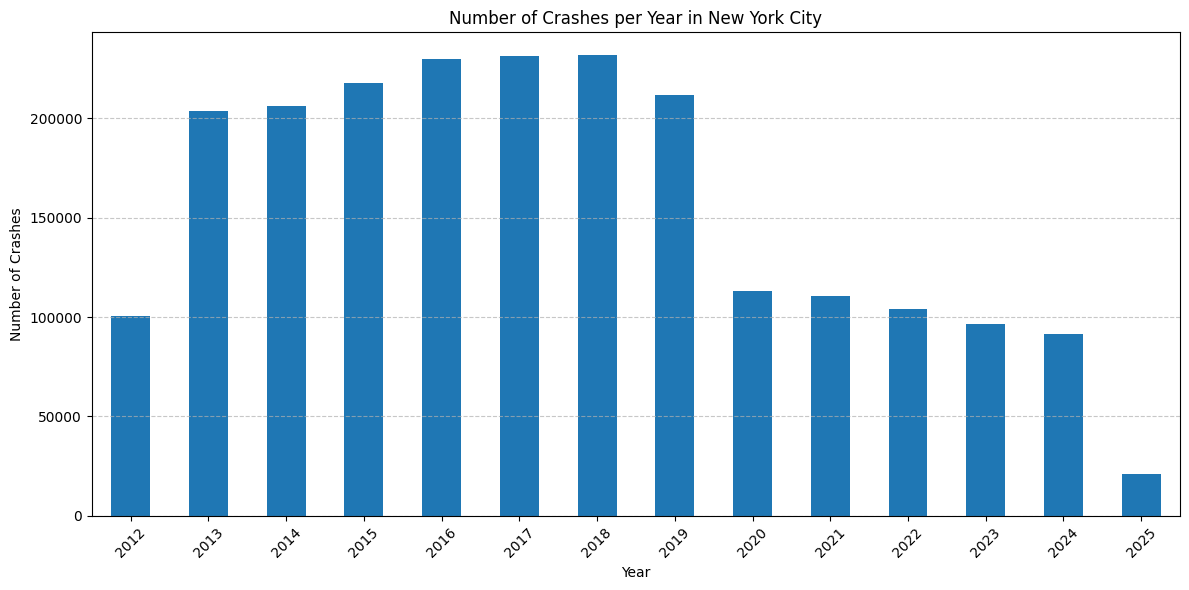

In [5]:
# Now let's get a basic overview of NYC collisions by year

# Extract year
df_vehicle_crashes["CRASH_YEAR"] = df_vehicle_crashes["CRASH DATE"].dt.year

# Count crashes per year
crashes_per_year = df_vehicle_crashes["CRASH_YEAR"].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
crashes_per_year.plot(kind="bar")
plt.title("Number of Crashes per Year in New York City")
plt.xlabel("Year")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\gisle\AppData\Local\Temp\ipykernel_25968\3643990322.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_vehicle_crashes["CRASH_HOUR"] = pd.to_datetime(df_vehicle_crashes["CRASH TIME"], errors="coerce").dt.hour


<Axes: title={'center': 'Collisions by Hour'}, xlabel='CRASH_HOUR'>

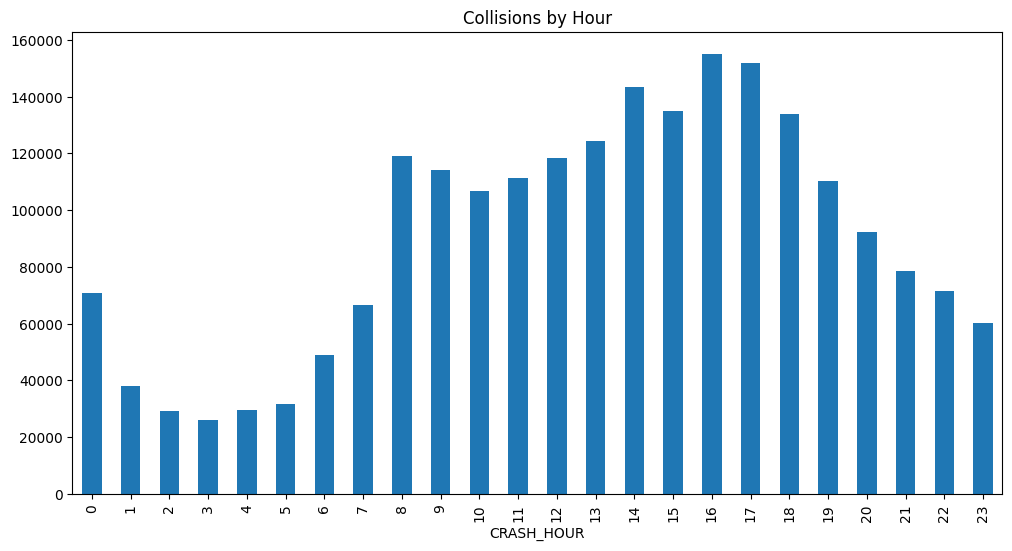

In [6]:
plt.figure(figsize=(12, 6))

df_vehicle_crashes["CRASH_HOUR"] = pd.to_datetime(df_vehicle_crashes["CRASH TIME"], errors="coerce").dt.hour
df_vehicle_crashes["CRASH_HOUR"].value_counts().sort_index().plot(kind="bar", title="Collisions by Hour")

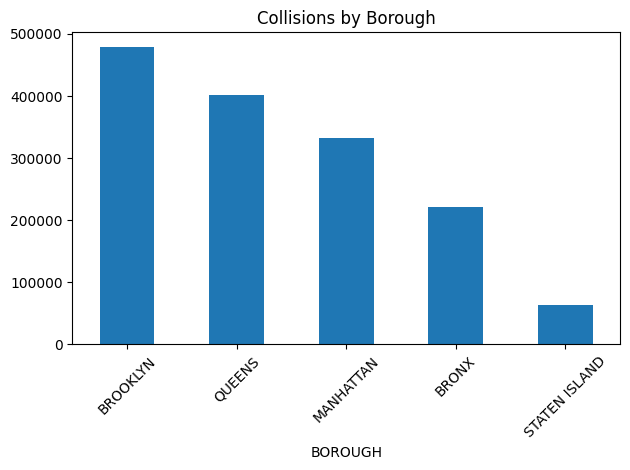

In [7]:
df_vehicle_crashes["BOROUGH"].value_counts().plot(kind="bar", title="Collisions by Borough")
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

# Now let's dive into the details of the vehicles involved

In [8]:
# We'll import the vehicle dataset to get more information about the vehicles involved in the crashes
df_vehicle = pd.read_parquet("../optimized_datasets/vehicle_crashes_vehicle_cleaned.parquet")

In [9]:
df_vehicle["VEHICLE_TYPE"] = (df_vehicle["VEHICLE_TYPE"].str.lower().str.strip())

vehicle_type_mapping = {
    # Common car types
    "sedan": "Sedan",
    "4 dr sedan": "Sedan",
    "2 dr sedan": "Sedan",
    
    "station wagon/sport utility vehicle": "SUV",
    "sport utility / station wagon": "SUV",
    "passenger vehicle": "Passenger Vehicle",
    "pick-up truck": "Pickup Truck",
    "pick-up": "Pickup Truck",
    "p/u": "Pickup Truck",
    "van": "Van",
    "box truck": "Box Truck",
    
    # Variations
    "taxi": "Taxi",
    "taxicab": "Taxi",
    "t.a.x.i": "Taxi",
    "taxy": "Taxi",
    
    "bus": "Bus",
    "bus ": "Bus",   # with trailing space
    "b u s": "Bus",
    
    "bike" : "bicycle",
    
    "motorcycle": "Motorcycle",
    "motorbike": "Motorcycle",
    "moped": "Moped",
    "motorscooter": "Motorcycle",
    
    "ambulance": "Ambulance",
    "ambul": "Ambulance",
    "amb": "Ambulance",
    
    "e-bike": "E-Bike",
    "e-scooter": "E-Scooter",
    
    # Catch-alls
    "unknown": "Unknown",
    "other": "Other"
}

df_vehicle["VEHICLE_TYPE_CLEANED"] = df_vehicle["VEHICLE_TYPE"].replace(vehicle_type_mapping)

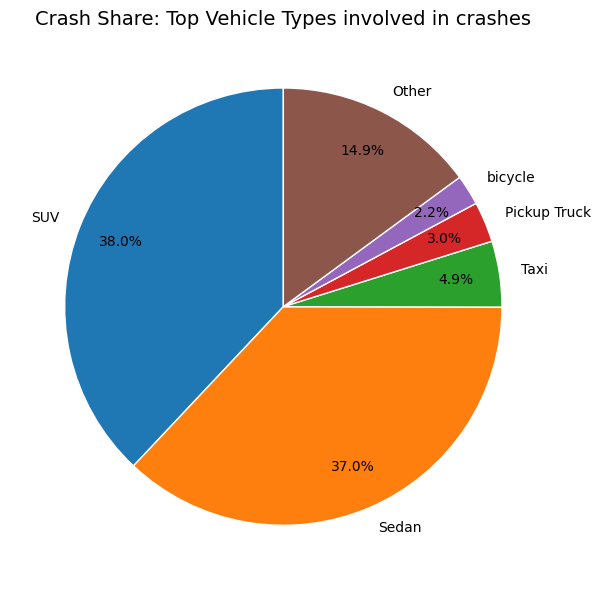

In [52]:
# 1) Compute full counts, dropping the unwanted categories
counts = (
    df_vehicle["VEHICLE_TYPE_CLEANED"]
    .value_counts()
    .drop(["Passenger Vehicle", "Unknown"], errors="ignore")
)

# 2) Take the top 5
top5 = counts.head(5)

# 3) Compute the “Other” bucket by summing everything else
other = counts.iloc[5:].sum()

# 
pie_data = top5.copy()
pie_data["Other"] = other

# 5) Plot
plt.figure(figsize=(10, 6))
pie_data.plot(
    kind="pie",
    labels=pie_data.index,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.8,            # pull labels in a bit
    labeldistance=1.1,          # move category labels out 
    wedgeprops={"edgecolor": "w"}
)
plt.title("Crash Share: Top Vehicle Types involved in crashes", fontsize=14)
plt.ylabel("")                  # remove default y-label
plt.tight_layout()
plt.show()

In [11]:
# List top 50 vehicle types
top_50_vehicle_types = df_vehicle["VEHICLE_TYPE_CLEANED"].value_counts().head(50)

# Drop 'Passenger Vehicle' and 'Unknown' as they don't provide useful information
top_50_vehicle_types = top_50_vehicle_types.drop(["Passenger Vehicle", "Unknown"], errors="ignore")

print(top_50_vehicle_types)

VEHICLE_TYPE_CLEANED
SUV                               1222075
Sedan                             1190151
Taxi                               156574
Pickup Truck                        96413
bicycle                             72153
Bus                                 70959
Van                                 69675
Box Truck                           57134
Other                               45969
large com veh(6 or more tires)      28604
Motorcycle                          28581
small com veh(4 tires)              26683
tractor truck diesel                22300
livery vehicle                      19441
Ambulance                           12961
E-Bike                              10845
dump                                 8794
E-Scooter                            7326
Moped                                7045
convertible                          6959
flat bed                             5517
pk                                   5321
garbage or refuse                    4926
carry all    

## One commonly discussed topic is the rise of SUVs and the danger that it imposes upon pedestrians and other vehicles due to its size and elevated height. How does it compare to the other vehicles on the list?

C:\Users\gisle\AppData\Local\Temp\ipykernel_25968\2664431413.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_sub["CONTRIBUTING_FACTOR_1"] = df_sub["CONTRIBUTING_FACTOR_1"].replace(
C:\Users\gisle\AppData\Local\Temp\ipykernel_25968\2664431413.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["CONTRIBUTING_FACTOR_1"] = df_sub["CONTRIBUTING_FACTOR_1"].replace(
C:\Users\gisle\AppData\Local\Temp\ipykernel_25968\2664431413.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

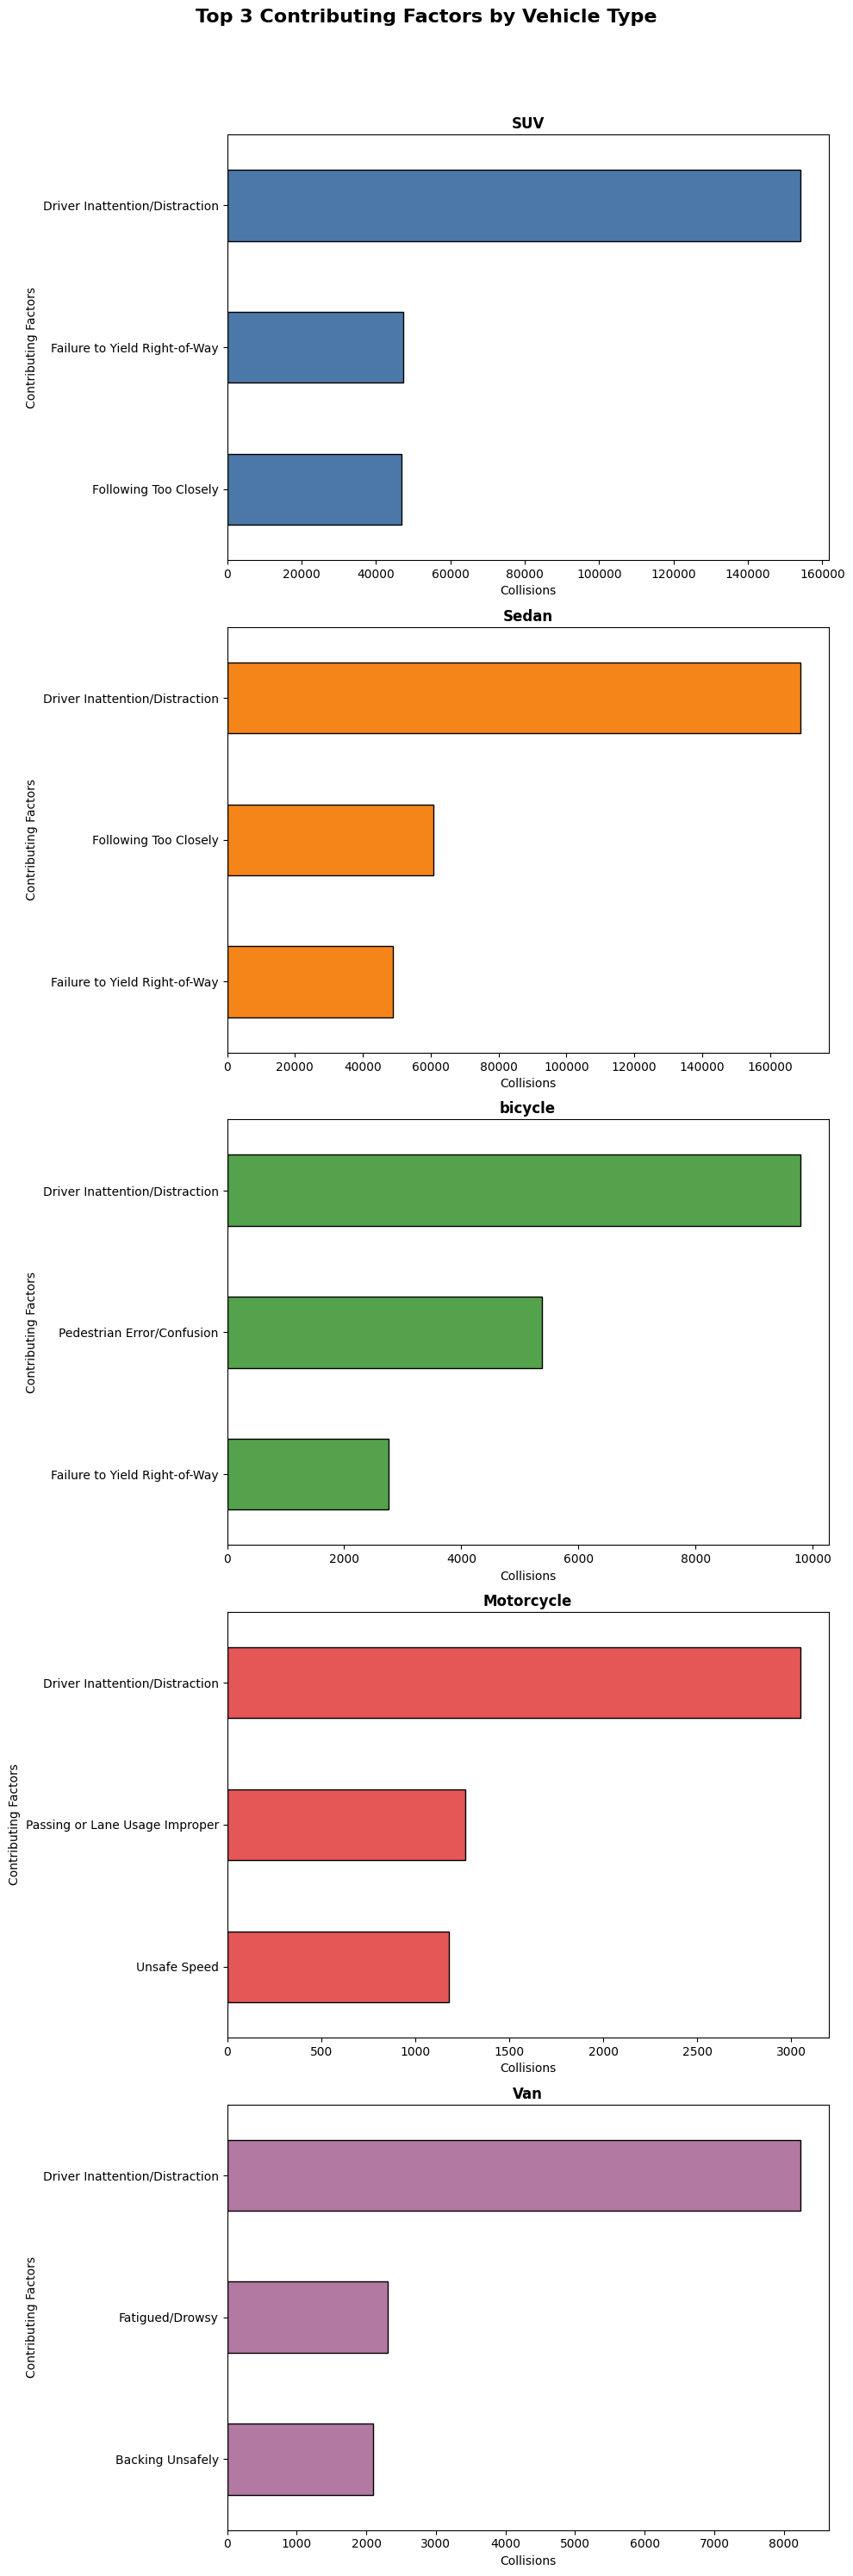

In [47]:
# Define vehicles that Javi might be interested in driving to deliver food
vehicle_types_to_compare = ["SUV", "Sedan", "bicycle", "Motorcycle", "Van"]

# Filter to selected vehicle types and remove "Unspecified" contributing factors
df_sub = df_vehicle[
    (df_vehicle["VEHICLE_TYPE_CLEANED"].isin(vehicle_types_to_compare)) &
    (df_vehicle["CONTRIBUTING_FACTOR_1"].str.lower() != "unspecified") &
    (df_vehicle["CONTRIBUTING_FACTOR_1"].str.lower() != "other vehicular")
]

df_sub["CONTRIBUTING_FACTOR_1"] = df_sub["CONTRIBUTING_FACTOR_1"].replace(
    "Pedestrian/Bicyclist/Other Pedestrian Error/Confusion", 
    "Pedestrian Error/Confusion"
)

color_map = {
    "SUV": "#4c78a8",
    "Sedan": "#f58518",
    "bicycle": "#54a24b",
    "Motorcycle": "#e45756",
    "Van": "#b279a2"
}

# Plot vertically stacked subplots: 5 rows × 1 column
fig, axes = plt.subplots(len(vehicle_types_to_compare), 1, figsize=(10, 30), sharex=False)

for ax, vt in zip(axes, vehicle_types_to_compare):
    top3 = (
        df_sub[df_sub["VEHICLE_TYPE_CLEANED"] == vt]
        .groupby("CONTRIBUTING_FACTOR_1")
        .size()
        .nlargest(3)
    )
    top3.plot(kind="barh", ax=ax, color=color_map[vt], edgecolor="black")
    ax.set_title(f"{vt}", fontsize=12, fontweight="bold", pad=5)
    ax.set_xlabel("Collisions")
    ax.set_ylabel("Contributing Factors")
    ax.invert_yaxis()  # Optional: Put the highest bar on top

# Main title
fig.suptitle("Top 3 Contributing Factors by Vehicle Type", fontweight="bold", fontsize=16, y=0.995)

# Layout adjustments
fig.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0.95)
plt.show()


# 3. Data Analysis

# Machine Learning?

Based on our analysis of attempting to find any linear relationships between two variables, this dataset contain very few continuous variables that we can apply linear regression analysis as we have gone through in the course. Below is our attempt at applying linear regression to find any linear trends between person injury and age and the limitations of linear regression on this particular dataset. There exist other combinations, but alternative combinations made little sense for us to even attempt to explore and thus we ended up attempting the combination of age and injury level.

-- Uncomment the code below to run it again if wanted --

In [ ]:
# df_person = pd.read_parquet("../optimized_datasets/vehicle_crashes_person_cleaned.parquet")

In [ ]:
# df_person.head(10)

In [ ]:
# print(df_person["CRASH_DATE"].min(), df_person["CRASH_DATE"].max())

In [ ]:
# Count number of people who are aged 0
# print(df_person[df_person["PERSON_AGE"] == 0].shape[0])

In [ ]:
"""

# Drop rows with missing age or injury
df_person = df_person.dropna(subset=["PERSON_AGE", "PERSON_INJURY"])

# Filter out unreasonable ages. We end up going with above age 0 because there were A HUGE DISPROPORTION of ages that were 0
# I believe that this is a data artefact and that when they calculated person_age = current_date - birth_date, they ended up with 0 for a lot of people as default
df_person = df_person[(df_person["PERSON_AGE"] > 0) & (df_person["PERSON_AGE"] <= 100)]

plt.figure(figsize=(10, 5))
df_person["PERSON_AGE"].plot(kind="hist", bins=30, edgecolor='black')
plt.title("Distribution of Person Ages")
plt.xlabel("Age")
plt.ylabel("Number of People")
plt.grid(True)
plt.tight_layout()
plt.show()

"""

'\n\n# Drop rows with missing age or injury\ndf_person = df_person.dropna(subset=["PERSON_AGE", "PERSON_INJURY"])\n\n# Filter out unreasonable ages. We end up going with above age 0 because there were A HUGE DISPROPORTION of ages that were 0\n# I believe that this is a data artefact and that when they calculated person_age = current_date - birth_date, they ended up with 0 for a lot of people as default\ndf_person = df_person[(df_person["PERSON_AGE"] > 0) & (df_person["PERSON_AGE"] <= 100)]\n\nplt.figure(figsize=(10, 5))\ndf_person["PERSON_AGE"].plot(kind="hist", bins=30, edgecolor=\'black\')\nplt.title("Distribution of Person Ages")\nplt.xlabel("Age")\nplt.ylabel("Number of People")\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n\n'

In [ ]:
"""

severity_map = {"Unspecified": 0, "Injured": 1, "Killed": 2}
df_person["injury_severity"] = df_person["PERSON_INJURY"].map(severity_map)

# Convert new column to a numeric dtype to do mean
df_person["injury_severity"] = df_person["injury_severity"].astype(float)

# Prepare x (age) and y (severity)
x = df_person["PERSON_AGE"].values
y = df_person["injury_severity"].values

# Compute regression slope (a) and intercept (b)
N = len(x)
x_mean = x.mean()
y_mean = y.mean()
a = (np.sum(x*y) - N*x_mean*y_mean) / (np.sum(x*x) - N*x_mean**2)
b = y_mean - a*x_mean

def calculate_r2(x, y, a, b):
    # Compute predicted y values
    y_pred = a * x + b

    # Compute SSR (Sum of Squared Residuals)
    ssr = np.sum((y - y_pred) ** 2)

    # Compute SST (Total Sum of Squares)
    sst = np.sum((y - np.mean(y)) ** 2)

    # Compute R-squared
    r2 = 1 - (ssr / sst)

    return r2

r2 = calculate_r2(x, y, a, b) 

"""

'\n\nseverity_map = {"Unspecified": 0, "Injured": 1, "Killed": 2}\ndf_person["injury_severity"] = df_person["PERSON_INJURY"].map(severity_map)\n\n# Convert new column to a numeric dtype to do mean\ndf_person["injury_severity"] = df_person["injury_severity"].astype(float)\n\n# Prepare x (age) and y (severity)\nx = df_person["PERSON_AGE"].values\ny = df_person["injury_severity"].values\n\n# Compute regression slope (a) and intercept (b)\nN = len(x)\nx_mean = x.mean()\ny_mean = y.mean()\na = (np.sum(x*y) - N*x_mean*y_mean) / (np.sum(x*x) - N*x_mean**2)\nb = y_mean - a*x_mean\n\ndef calculate_r2(x, y, a, b):\n    # Compute predicted y values\n    y_pred = a * x + b\n\n    # Compute SSR (Sum of Squared Residuals)\n    ssr = np.sum((y - y_pred) ** 2)\n\n    # Compute SST (Total Sum of Squares)\n    sst = np.sum((y - np.mean(y)) ** 2)\n\n    # Compute R-squared\n    r2 = 1 - (ssr / sst)\n\n    return r2\n\nr2 = calculate_r2(x, y, a, b) \n\n'

In [ ]:
"""

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.02, s=5)
x_range = np.linspace(x.min(), x.max(), 200)
plt.plot(x_range, a*x_range + b, color="red", linestyle="--",
         label=f"y = {a:.3f}·age + {b:.2f}\nR² = {r2:.2f}")
plt.xlabel("Person Age")
plt.ylabel("Injury Severity\n(0=Unspecified, 1=Injured, 2=Killed)")
plt.title("Age vs. Injury Severity")
plt.legend()
plt.tight_layout()
plt.show()

"""

'\n\n# Plot\nplt.figure(figsize=(8, 5))\nplt.scatter(x, y, alpha=0.02, s=5)\nx_range = np.linspace(x.min(), x.max(), 200)\nplt.plot(x_range, a*x_range + b, color="red", linestyle="--",\n         label=f"y = {a:.3f}·age + {b:.2f}\nR² = {r2:.2f}")\nplt.xlabel("Person Age")\nplt.ylabel("Injury Severity\n(0=Unspecified, 1=Injured, 2=Killed)")\nplt.title("Age vs. Injury Severity")\nplt.legend()\nplt.tight_layout()\nplt.show()\n\n'

As we can observe, given to the very discrete nature of the injury severity attribute, we get "jumps" in data observations on the y axis. Because data points aren't properly scattered, linear regression in this case gives little information on the relationship between the two variables other than the R^2 value being so low, that there is an extremely weak linear relationship between the variables.

# 4. Genre - Mursal

# 5. Visualizations
What visualizations we ended up choosing for the website and how that contributes to the story?

# 6. Discussion - Joachim

# 7. Contributions

# 8. References